In [12]:
import pandas as pd
import pickle as pkl
import numpy as np

import matplotlib.pyplot as plt

import scanpy as sc
%matplotlib inline
import matplotlib

import scanpy as sc
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import glob

### Random baseline

In [13]:
def generate_random_rounds(all_genes, round0=None, rounds = 16, sample_size=64):
    past_set =list(all_genes)
    random_rounds = {}
    if round0 is not None:
        random_rounds[0] = round0
    else:
        random_rounds[0] = np.random.choice(all_genes, sample_size)
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_size)])
        past_set = list(selection_set)
        
    return random_rounds

def generate_random_rounds_custom(all_genes, rounds = 16, sample_sizes=None):
    past_set =list(all_genes)
    random_rounds = {}
    random_rounds[0] = []
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_sizes[i])])
        past_set = list(selection_set)
        
    return random_rounds

def return_hits(list_):
    return list(set(list_).intersection(set(topmovers)))

def get_all_sampled_genes(exp_path):
    all_sampled_genes = []
    num_rounds = len(glob.glob(exp_path + '*'))
    for i in range(num_rounds):
        exp_path_ = exp_path + str(i) + '.npy'
        all_sampled_genes.append(np.load(exp_path_))
    return all_sampled_genes

def get_successful_sample_sizes(sampled_genes):
    sizes = []
    prev_size = 0
    for sample in sampled_genes:
        sizes.append(len(sample)-prev_size)
        prev_size = prev_size + sizes[-1]
    return sizes

def return_hits(arr):
    return list(set(arr).intersection(set(topmovers)))

In [14]:
REPS = np.arange(1, 10).astype('str')
ACQUISITION_FUNCTIONS = ["random", "softuncertain", "topuncertain",
                         "marginsample", "coreset", "badge",
                         "kmeans_embedding", "kmeans_data"]

dataset = 'sanchez'

if dataset =='scharenberg':
    sample_size= 32
else:
    sample_size= 128

num_steps = 5
ai_steps = 5

data_formal_name = {'scharenberg': 'Scharenberg22',
                 'ifng': 'Schmidt22 (IFNG)',
                 'il2': 'Schmidt22 (IL2)',
                 'steinhart': 'Steinhart',
                 'sanchez': 'Sanchez21',
                 'carnevale_adenosine': 'Carnevale22'}

data_name_map = {'scharenberg': 'Scharenberg22',
                 'ifng': 'IFNG',
                 'il2': 'IL2',
                 'steinhart': 'Steinhart_crispra_GD2_D22',
                 'scharenberg': 'Scharenberg22',
                 'sanchez': 'Sanchez21',
                 'carnevale_adenosine': 'Carnevale22_Adenosine'}

result_name_map = {'scharenberg': 'scharenberg_2022',
                 'ifng': 'Schmidt_2021_ifng',
                 'il2': 'Schmidt_2021_il2',
                 'steinhart': 'steinhart_2024_crispra_GD2_D22',
                 'scharenberg': 'scharenberg_2022',
                 'sanchez': 'sanchez_2021_down',
                 'carnevale_adenosine': 'Carnevale_2022_Adenosine'}

ai_run_name = {#'scharenberg': '32_Scharenberg',
                 'ifng': 'IFNG',
                 'il2': 'IL2',
                 'steinhart': 'Steinhart',
                 'sanchez': 'Sanchez',
                 'carnevale_adenosine': '128_Carnevale22_Adenosine'}

    
num_reps = len(REPS)
batch_size=sample_size

data_df = pd.read_csv('/dfs/user/yhr/AI_RA/research_assistant/datasets/ground_truth_'+data_name_map[dataset]+'.csv')
topmovers = np.load('/dfs/user/yhr/AI_RA/research_assistant/datasets/topmovers_'+data_name_map[dataset]+'.npy')
ai_data_path = glob.glob(f'/dfs/scratch0/jianv/bio-logs/agent-final/v4_all3_again50*{ai_run_name[dataset]}*')[0]
try:
    data_df = data_df.rename(columns={'0':'Gene', '1':'Score'})
except:
    pass

all_genes = data_df['Gene'].values
data_df = data_df.set_index('Gene')

In [15]:
## Get essential genes

essential_genes = '/dfs/user/yhr/bagel/CEGv2.txt'
essential_genes = pd.read_csv(essential_genes, delimiter='\t')['GENE'].tolist()

### Checking gene list overlap

In [24]:
main_dir = '/dfs/scratch0/jianv/bio-logs/agent-final/v4_all3_again50'
all_selected = {}

for dataset, run_name in ai_run_name.items():
    data_path = glob.glob(main_dir + f'*{run_name}*')[0]
    topmovers = np.load('/dfs/user/yhr/AI_RA/research_assistant/datasets/topmovers_'+data_name_map[dataset]+'.npy')
    all_selected[dataset] = set()
    for rep in range(1, num_reps+1):
        rep=str(rep)
        try:
            sampled = set(np.load(data_path + f'/dummy_summary{rep}/sampled_genes_5.npy'))
            hits = set(sampled).intersection(set(topmovers))
            #hits = set(hits).difference(set(essential_genes))
            all_selected[dataset] = all_selected[dataset].union(hits)
            
        except:
            pass


In [25]:
intersection_heatmap = np.zeros([len(all_selected), len(all_selected)])

for idx_i, i in enumerate(ai_run_name.keys()):
    for idx_j, j in enumerate(ai_run_name.keys()):
        intersection = len(set(all_selected[i]).intersection(set(all_selected[j])))
        union = len(set(all_selected[i]).union(set(all_selected[j])))
        intersection_heatmap[idx_i][idx_j] = intersection/union

In [38]:
ai_run_name['carnevale_adenosine'] = 'Carnevale22'

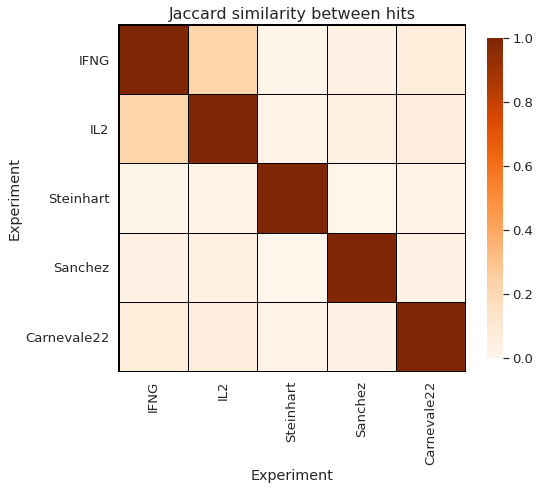

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Since the actual data is not provided, I will generate a random heatmap data as a placeholder.
# The following code will be based on this generated data.
data = intersection_heatmap

# Create a more professional heatmap for an academic paper
sns.set(style="whitegrid", font_scale=1.2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 0, as_cmap=True)
#cmap = sns.light_palette("reds", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data, cmap='Oranges', vmin=0, vmax=1.0, linecolor='black',
            square=True, linewidths=.5, cbar_kws={"shrink": .9})

# Set labels and title
plt.ylabel('Experiment')
plt.xlabel('Experiment')
plt.title('Jaccard similarity between hits', fontsize=16)

# Adding a border
ax.patch.set_edgecolor('black')  # Set the border color
ax.patch.set_linewidth('2')      # Set the border width


# Improve the appearance of the plot
plt.tight_layout()


plt.xticks([0.5,1.5,2.5,3.5,4.5], ai_run_name.values(), rotation=90)
plt.yticks([0.5,1.5,2.5,3.5,4.5], ai_run_name.values(), rotation=0)

# Save the figure
plt.savefig('./heatmap_hits.svg')

# Show the plot
plt.show()


In [8]:
base_fname = '/dfs/user/yhr/genedisco/genedisco/results/'

fnames = [
'Schmidt_2021_ifng_coreset_',
'Schmidt_2021_il2_coreset_',
'sanchez_2021_down_coreset_',
'steinhart_2024_crispra_GD2_D22_coreset_',
'Carnevale_2022_Adenosine_coreset_']

ml_data_name_map = {
    'Schmidt_2021_ifng_coreset_' : 'IFNG',
    'Schmidt_2021_il2_coreset_' : 'IL2',
    'sanchez_2021_down_coreset_' : 'Sanchez21',
    'steinhart_2024_crispra_GD2_D22_coreset_' : 'Steinhart_crispra_GD2_D22',
    'Carnevale_2022_Adenosine_coreset_' : 'Carnevale22_Adenosine'
}

In [9]:
all_selected = {}

for f in fnames:
    topmovers = np.load('/dfs/user/yhr/AI_RA/research_assistant/datasets/topmovers_'+ml_data_name_map[f]+'.npy')
    print(f)
    all_selected[f] = set()
    for idx in range(1, 11):
        sampled = set(pd.read_pickle(base_fname + f + str(idx) +'/cycle_4/selected_indices.pickle'))
        hits = set(sampled).intersection(set(topmovers))
        hits = set(hits).difference(set(essential_genes))
        all_selected[f] = all_selected[f].union(hits)

Schmidt_2021_ifng_coreset_
Schmidt_2021_il2_coreset_
sanchez_2021_down_coreset_
steinhart_2024_crispra_GD2_D22_coreset_
Carnevale_2022_Adenosine_coreset_


In [10]:
intersection_heatmap = np.zeros([len(all_selected), len(all_selected)])

for idx_i, i in enumerate(fnames):
    for idx_j, j in enumerate(fnames):
        intersection = len(set(all_selected[i]).intersection(set(all_selected[j])))
        union = len(set(all_selected[i]).union(set(all_selected[j])))
        intersection_heatmap[idx_i][idx_j] = intersection/union

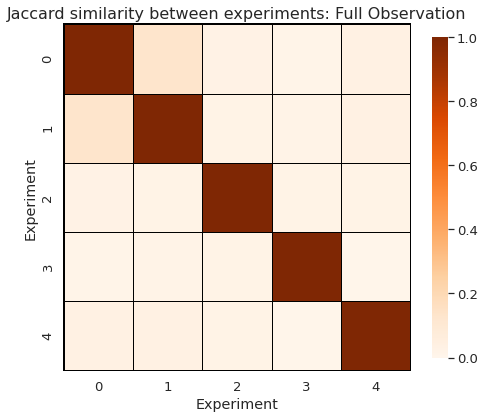

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Since the actual data is not provided, I will generate a random heatmap data as a placeholder.
# The following code will be based on this generated data.
data = intersection_heatmap

# Create a more professional heatmap for an academic paper
sns.set(style="whitegrid", font_scale=1.2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 0, as_cmap=True)
#cmap = sns.light_palette("reds", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data, cmap='Oranges', vmin=0, vmax=1.0, linecolor='black',
            square=True, linewidths=.5, cbar_kws={"shrink": .9})

# Set labels and title
plt.ylabel('Experiment')
plt.xlabel('Experiment')
plt.title('Jaccard similarity between experiments: Full Observation', fontsize=16)

# Adding a border
ax.patch.set_edgecolor('black')  # Set the border color
ax.patch.set_linewidth('2')      # Set the border width


# Improve the appearance of the plot
plt.tight_layout()

# Save the figure
plt.savefig('./heatmap_full_obs.png')

# Show the plot
plt.show()
